--------------------------------------------------------------------------------

#NNDL Project

####Deep Learning Methods for Quality Enhancement of Satellite Remote Sensing Images

###Submitted by :

###Shravan Bhat

###Rohit Yatgiri

--------------------------------------------------------------------------------



-> Download and upload this folder into your drive account.

-> The main directory named as "nndl_project_files" and the subdirectories should be : "data" and "snapshots".

-> Now run the cells below.


---------------
#Mount Drive

---------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


--------------------------------
#Import packages

-------------------------------

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import torch.utils.data as data
from PIL import Image
import glob
import random
import cv2
from torchvision.models.vgg import vgg16
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import sys
import argparse
import time
import matplotlib.pyplot as plt
import os
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
from math import log10, sqrt
os.chdir("drive/MyDrive/nndl_project_files")

---------------------
#The Model

----------------------

In [ ]:
class my_model(nn.Module):

	def __init__(self):
		super(my_model, self).__init__()

		self.relu = nn.ReLU(inplace=True)

		number_f = 32
		self.e_conv1 = nn.Conv2d(3,number_f,3,1,1,bias=True)
		self.e_conv2 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
		self.e_conv3 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
		self.e_conv4 = nn.Conv2d(number_f,number_f,3,1,1,bias=True)
		self.e_conv5 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True)
		self.e_conv6 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True)
		self.e_conv7 = nn.Conv2d(number_f*2,24,3,1,1,bias=True)

		self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
		self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)



	def forward(self, x):

		x1 = self.relu(self.e_conv1(x))
		x2 = self.relu(self.e_conv2(x1))
		x3 = self.relu(self.e_conv3(x2))
		x4 = self.relu(self.e_conv4(x3))

		x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
		x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))

		x_r = torch.tanh(self.e_conv7(torch.cat([x1,x6],1)))
		r1,r2,r3,r4,r5,r6,r7,r8 = torch.split(x_r, 3, dim=1)


		x = x + r1*(torch.pow(x,2)-x)
		x = x + r2*(torch.pow(x,2)-x)
		x = x + r3*(torch.pow(x,2)-x)
		enhance_image_1 = x + r4*(torch.pow(x,2)-x)
		x = enhance_image_1 + r5*(torch.pow(enhance_image_1,2)-enhance_image_1)
		x = x + r6*(torch.pow(x,2)-x)
		x = x + r7*(torch.pow(x,2)-x)
		enhance_image = x + r8*(torch.pow(x,2)-x)
		r = torch.cat([r1,r2,r3,r4,r5,r6,r7,r8],1)
		return enhance_image_1, enhance_image, r

--------------------------------------
#Dataloader
This cell contains the utility functions for the dataloader, which will be used during testing/training to arrange the dataset as required

------------------------

In [ ]:
random.seed(1143)


def populate_train_list(lowlight_images_path):

	image_list_lowlight = glob.glob(lowlight_images_path + "*.jpg")

	train_list = image_list_lowlight

	random.shuffle(train_list)

	return train_list



class lowlight_loader():

	def __init__(self, lowlight_images_path):

		self.train_list = populate_train_list(lowlight_images_path)
		self.size = 256

		self.data_list = self.train_list
		print("Total training examples:", len(self.train_list))




	def __getitem__(self, index):

		data_lowlight_path = self.data_list[index]

		data_lowlight = Image.open(data_lowlight_path)

		data_lowlight = data_lowlight.resize((self.size,self.size), Image.ANTIALIAS)

		data_lowlight = (np.asarray(data_lowlight)/255.0)
		data_lowlight = torch.from_numpy(data_lowlight).float()

		return data_lowlight.permute(2,0,1)

	def __len__(self):
		return len(self.data_list)

-----------------------
#Loss functions

-----------------------

In [ ]:
class L_color(nn.Module):

    def __init__(self):
        super(L_color, self).__init__()

    def forward(self, x ):

        b,c,h,w = x.shape

        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = torch.pow(mr-mg,2)
        Drb = torch.pow(mr-mb,2)
        Dgb = torch.pow(mb-mg,2)
        k = torch.pow(torch.pow(Drg,2) + torch.pow(Drb,2) + torch.pow(Dgb,2),0.5)
        return k


class L_spa(nn.Module):

    def __init__(self):
        super(L_spa, self).__init__()
        # print(1)kernel = torch.FloatTensor(kernel).unsqueeze(0).unsqueeze(0)
        kernel_left = torch.FloatTensor( [[0,0,0],[-1,1,0],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_right = torch.FloatTensor( [[0,0,0],[0,1,-1],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_up = torch.FloatTensor( [[0,-1,0],[0,1, 0 ],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_down = torch.FloatTensor( [[0,0,0],[0,1, 0],[0,-1,0]]).cuda().unsqueeze(0).unsqueeze(0)
        self.weight_left = nn.Parameter(data=kernel_left, requires_grad=False)
        self.weight_right = nn.Parameter(data=kernel_right, requires_grad=False)
        self.weight_up = nn.Parameter(data=kernel_up, requires_grad=False)
        self.weight_down = nn.Parameter(data=kernel_down, requires_grad=False)
        self.pool = nn.AvgPool2d(4)

    def forward(self, org , enhance ):
        b,c,h,w = org.shape

        org_mean = torch.mean(org,1,keepdim=True)
        enhance_mean = torch.mean(enhance,1,keepdim=True)

        org_pool =  self.pool(org_mean)
        enhance_pool = self.pool(enhance_mean)

        weight_diff =torch.max(torch.FloatTensor([1]).cuda() + 10000*torch.min(org_pool - torch.FloatTensor([0.3]).cuda(),torch.FloatTensor([0]).cuda()),torch.FloatTensor([0.5]).cuda())
        E_1 = torch.mul(torch.sign(enhance_pool - torch.FloatTensor([0.5]).cuda()) ,enhance_pool-org_pool)


        D_org_letf = F.conv2d(org_pool , self.weight_left, padding=1)
        D_org_right = F.conv2d(org_pool , self.weight_right, padding=1)
        D_org_up = F.conv2d(org_pool , self.weight_up, padding=1)
        D_org_down = F.conv2d(org_pool , self.weight_down, padding=1)

        D_enhance_letf = F.conv2d(enhance_pool , self.weight_left, padding=1)
        D_enhance_right = F.conv2d(enhance_pool , self.weight_right, padding=1)
        D_enhance_up = F.conv2d(enhance_pool , self.weight_up, padding=1)
        D_enhance_down = F.conv2d(enhance_pool , self.weight_down, padding=1)

        D_left = torch.pow(D_org_letf - D_enhance_letf,2)
        D_right = torch.pow(D_org_right - D_enhance_right,2)
        D_up = torch.pow(D_org_up - D_enhance_up,2)
        D_down = torch.pow(D_org_down - D_enhance_down,2)
        E = (D_left + D_right + D_up +D_down)
        # E = 25*(D_left + D_right + D_up +D_down)

        return E
class L_exp(nn.Module):

    def __init__(self,patch_size,mean_val):
        super(L_exp, self).__init__()
        # print(1)
        self.pool = nn.AvgPool2d(patch_size)
        self.mean_val = mean_val
    def forward(self, x ):

        b,c,h,w = x.shape
        x = torch.mean(x,1,keepdim=True)
        mean = self.pool(x)

        d = torch.mean(torch.pow(mean- torch.FloatTensor([self.mean_val] ).cuda(),2))
        return d

class L_TV(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(L_TV,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h =  (x.size()[2]-1) * x.size()[3]
        count_w = x.size()[2] * (x.size()[3] - 1)
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size

class Sa_Loss(nn.Module):
    def __init__(self):
        super(Sa_Loss, self).__init__()
        # print(1)
    def forward(self, x ):
        # self.grad = np.ones(x.shape,dtype=np.float32)
        b,c,h,w = x.shape
        # x_de = x.cpu().detach().numpy()
        r,g,b = torch.split(x , 1, dim=1)
        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Dr = r-mr
        Dg = g-mg
        Db = b-mb
        k =torch.pow( torch.pow(Dr,2) + torch.pow(Db,2) + torch.pow(Dg,2),0.5)
        # print(k)


        k = torch.mean(k)
        return k

class perception_loss(nn.Module):
    def __init__(self):
        super(perception_loss, self).__init__()
        features = vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential()
        self.to_relu_2_2 = nn.Sequential()
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), features[x])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        h_relu_3_3 = h
        h = self.to_relu_4_3(h)
        h_relu_4_3 = h
        # out = (h_relu_1_2, h_relu_2_2, h_relu_3_3, h_relu_4_3)
        return h_relu_4_3

----------------------------------
#Function to test the performance of the already trained model (using snapshots of pretrained weights)

####The test data is found in "data/test_data/" and the light-enhanced results of these images are stored in "result/"

--------------------------------

In [ ]:
def lowlight(image_path, weights_path):
	os.environ['CUDA_VISIBLE_DEVICES']='0'
	data_lowlight = Image.open(image_path)



	data_lowlight = (np.asarray(data_lowlight)/255.0)
	# print(data_lowlight.shape)

	data_lowlight = torch.from_numpy(data_lowlight).float()
	data_lowlight = data_lowlight.permute(2,0,1)
	data_lowlight = data_lowlight.cuda().unsqueeze(0)

	my_net = my_model().cuda()
	my_net.load_state_dict(torch.load(weights_path))
	start = time.time()
	_,enhanced_image,_ = my_net(data_lowlight)

	end_time = (time.time() - start)
	# print(end_time)
	image_path = image_path.replace('test_data','result')
	result_path = image_path
	if not os.path.exists(image_path.replace('/'+image_path.split("/")[-1],'')):
		os.makedirs(image_path.replace('/'+image_path.split("/")[-1],''))

	torchvision.utils.save_image(enhanced_image, result_path)




with torch.no_grad():
	filePath = 'data/test_data/'

	file_list = os.listdir(filePath)

	for file_name in file_list:
		test_list = glob.glob(filePath+file_name+"/*")
		for image in test_list:
			print("Path of image being tested : ",image)
			lowlight(image, 'snapshots/Epoch199.pth')

Path of image being tested :  data/test_data/DICM/13.jpg
Path of image being tested :  data/test_data/DICM/09.jpg
Path of image being tested :  data/test_data/DICM/60.jpg
Path of image being tested :  data/test_data/DICM/35.jpg
Path of image being tested :  data/test_data/DICM/31.jpg
Path of image being tested :  data/test_data/DICM/45.jpg
Path of image being tested :  data/test_data/DICM/16.jpg
Path of image being tested :  data/test_data/DICM/41.jpg
Path of image being tested :  data/test_data/DICM/49.jpg
Path of image being tested :  data/test_data/DICM/62.jpg
Path of image being tested :  data/test_data/DICM/47.jpg
Path of image being tested :  data/test_data/DICM/11.jpg
Path of image being tested :  data/test_data/DICM/65.jpg
Path of image being tested :  data/test_data/DICM/56.jpg
Path of image being tested :  data/test_data/DICM/25.jpg
Path of image being tested :  data/test_data/DICM/57.jpg
Path of image being tested :  data/test_data/DICM/15.jpg
Path of image being tested :  d

--------------------------------
#Low-Light vs Enhanced Image Visualization using pre-trained weights

---------------------------------

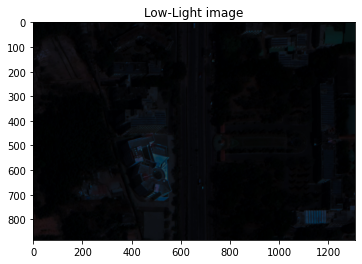

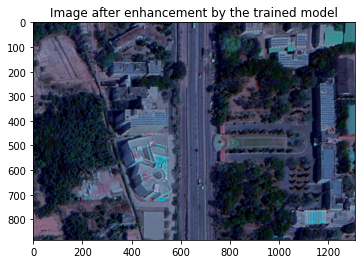

------------------------------------------------------


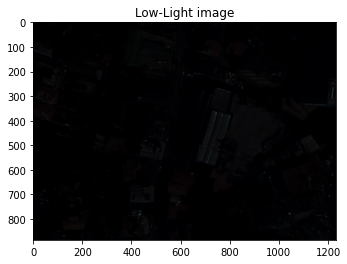

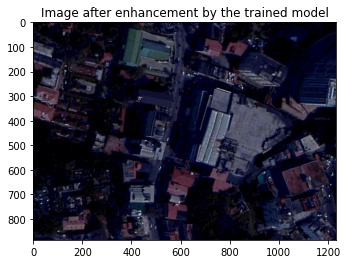

------------------------------------------------------


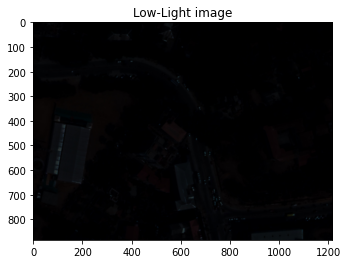

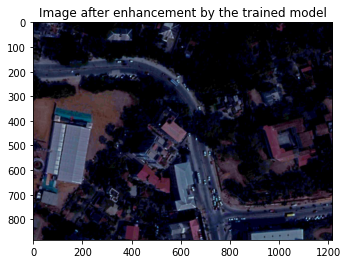

------------------------------------------------------


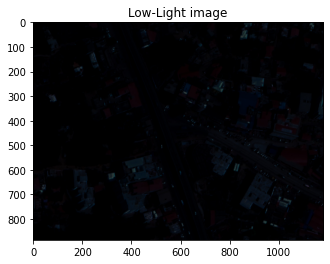

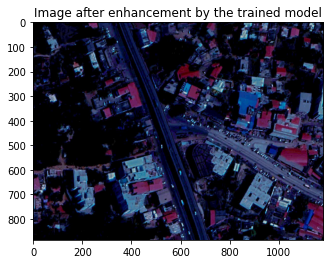

------------------------------------------------------


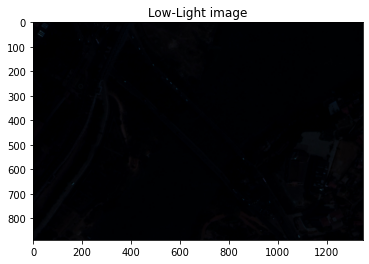

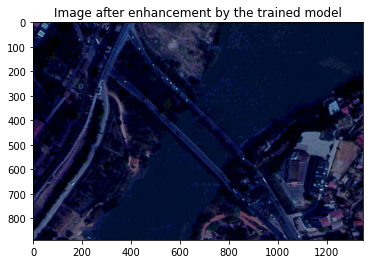

------------------------------------------------------


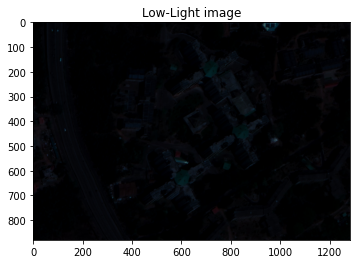

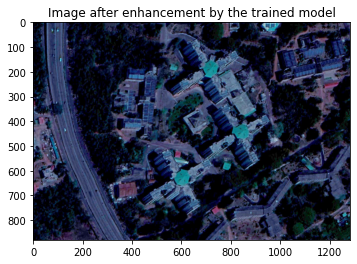

------------------------------------------------------


In [ ]:
path1 = "data/test_data/surathkal/"
path2 = "data/result/surathkal/"
files = os.listdir("data/result/surathkal")
for x in files:
  plt.imshow(plt.imread(path1 + x))
  plt.title("Low-Light image")
  plt.show()
  plt.imshow(plt.imread(path2 + x))
  plt.title("Image after enhancement by the trained model")
  plt.show()
  print("------------------------------------------------------")

------------------------------------
#Training the model
##Do not run unless you wish to re-train the model.

Warning : The snapshots stored will get overwritten.

----------------------------------

In [ ]:
class premake():
  def __init__(self):
    self.display_iter=10
    self.grad_clip_norm=0.1
    self.load_pretrain=True
    self.lowlight_images_path='data/train_data/'
    self.lr=0.0001
    self.num_epochs=200
    self.num_workers=4
    self.pretrain_dir='snapshots/Epoch99.pth'
    self.snapshot_iter=10
    self.snapshots_folder='snapshots/'
    self.train_batch_size=8
    self.val_batch_size=4
    self.weight_decay=0.0001



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)



def train(config):
  losslist = []
  os.environ['CUDA_VISIBLE_DEVICES']='0'

  my_net = my_model().cuda()
  my_net.apply(weights_init)
  if config.load_pretrain == True:
	    my_net.load_state_dict(torch.load(config.pretrain_dir))
  train_dataset = lowlight_loader(config.lowlight_images_path)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=config.num_workers, pin_memory=True)



  L_color1 = L_color()
  L_spa1 = L_spa()

  L_exp1 = L_exp(16,0.6)
  L_TV1 = L_TV()


  optimizer = torch.optim.Adam(my_net.parameters(), lr=config.lr, weight_decay=config.weight_decay)

  my_net.train()
  for epoch in range(config.num_epochs):
    t1 = time.time()
    for iteration, img_lowlight in enumerate(train_loader):
      img_lowlight = img_lowlight.cuda()

      enhanced_image_1,enhanced_image,A  = my_net(img_lowlight)

      Loss_TV = 200*L_TV1(A)

      loss_spa = torch.mean(L_spa1(enhanced_image, img_lowlight))

      loss_col = 5*torch.mean(L_color1(enhanced_image))

      loss_exp = 10*torch.mean(L_exp1(enhanced_image))


      # best_loss
      loss =  Loss_TV + loss_spa + loss_col + loss_exp
      #

      losslist.append(loss)
      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(my_net.parameters(),config.grad_clip_norm)
      optimizer.step()

      if ((iteration+1) % config.display_iter) == 0:
        print("Epoch : ", epoch, " Iteration : ", iteration+1)
      if ((iteration+1) % config.snapshot_iter) == 0:
        torch.save(my_net.state_dict(), config.snapshots_folder + "Epoch" + str(epoch) + '.pth')

      t2 = time.time()
      dt = t2 - t1
    print('----------------------------------------------------------------------------')
    print("\nEnd of epoch ", epoch, ". Time taken for its completion = ", dt, "seconds \n")
    print('----------------------------------------------------------------------------')
  return(losslist, train_loader)


config = premake()
if not os.path.exists(config.snapshots_folder):
  os.mkdir(config.snapshots_folder)

losslist, train_loader = train(config)

Streaming output truncated to the last 5000 lines.
Epoch :  33  Iteration :  110
Epoch :  33  Iteration :  120
Epoch :  33  Iteration :  130
Epoch :  33  Iteration :  140
Epoch :  33  Iteration :  150
Epoch :  33  Iteration :  160
Epoch :  33  Iteration :  170
Epoch :  33  Iteration :  180
Epoch :  33  Iteration :  190
Epoch :  33  Iteration :  200
Epoch :  33  Iteration :  210
Epoch :  33  Iteration :  220
Epoch :  33  Iteration :  230
Epoch :  33  Iteration :  240
Epoch :  33  Iteration :  250
----------------------------------------------------------------------------

End of epoch  33 . Time taken for its completion =  36.66076374053955 seconds 

----------------------------------------------------------------------------
Epoch :  34  Iteration :  10
Epoch :  34  Iteration :  20
Epoch :  34  Iteration :  30
Epoch :  34  Iteration :  40
Epoch :  34  Iteration :  50
Epoch :  34  Iteration :  60
Epoch :  34  Iteration :  70
Epoch :  34  Iteration :  80
Epoch :  34  Iteration :  90
Epo

------------------------------
##Obtaining enhanced versions of the test images using the weights trained by the user in the previous cell (if the training cell was run, else it considers the pre-trained weights by us, the authors of the notebook.

-----------------------------------


In [ ]:
with torch.no_grad():
	filePath = 'data/test_data/'

	file_list = os.listdir(filePath)

	for file_name in file_list:
		test_list = glob.glob(filePath+file_name+"/*")
		for image in test_list:
			print(image)
			lowlight(image, 'snapshots/Epoch199.pth')

data/test_data/DICM/13.jpg
data/test_data/DICM/09.jpg
data/test_data/DICM/60.jpg
data/test_data/DICM/35.jpg
data/test_data/DICM/31.jpg
data/test_data/DICM/45.jpg
data/test_data/DICM/16.jpg
data/test_data/DICM/41.jpg
data/test_data/DICM/49.jpg
data/test_data/DICM/62.jpg
data/test_data/DICM/47.jpg
data/test_data/DICM/11.jpg
data/test_data/DICM/65.jpg
data/test_data/DICM/56.jpg
data/test_data/DICM/25.jpg
data/test_data/DICM/57.jpg
data/test_data/DICM/15.jpg
data/test_data/DICM/26.jpg
data/test_data/DICM/48.jpg
data/test_data/DICM/03.jpg
data/test_data/DICM/69.jpg
data/test_data/DICM/34.jpg
data/test_data/DICM/39.jpg
data/test_data/DICM/50.jpg
data/test_data/DICM/19.jpg
data/test_data/DICM/66.jpg
data/test_data/DICM/30.jpg
data/test_data/DICM/10.jpg
data/test_data/DICM/64.jpg
data/test_data/DICM/06.jpg
data/test_data/DICM/18.jpg
data/test_data/DICM/29.jpg
data/test_data/DICM/52.jpg
data/test_data/DICM/28.jpg
data/test_data/DICM/67.jpg
data/test_data/DICM/20.jpg
data/test_data/DICM/38.jpg
d

-----------------------------
#Low-Light vs Enhanced Image Visualization

------------------------------

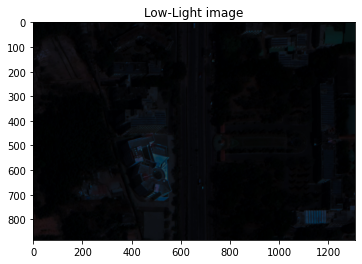

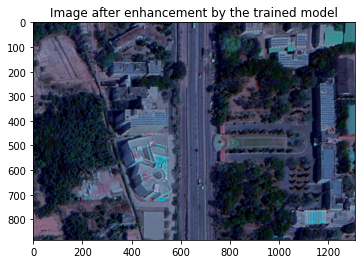

------------------------------------------------------


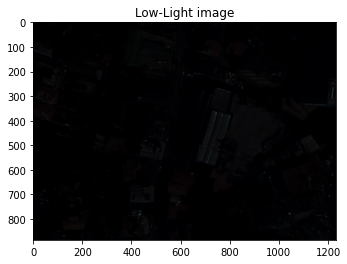

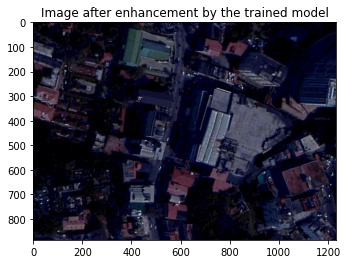

------------------------------------------------------


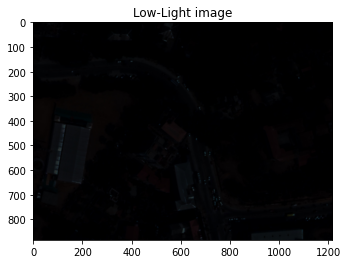

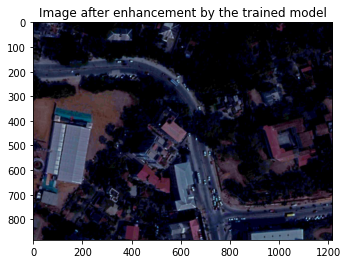

------------------------------------------------------


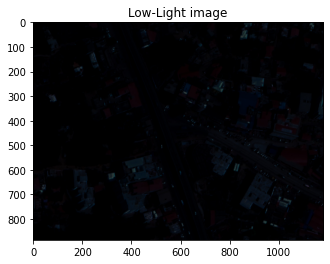

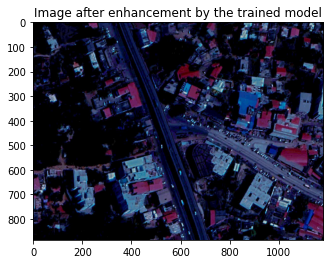

------------------------------------------------------


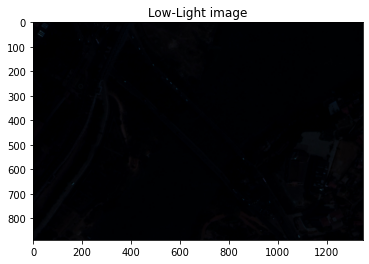

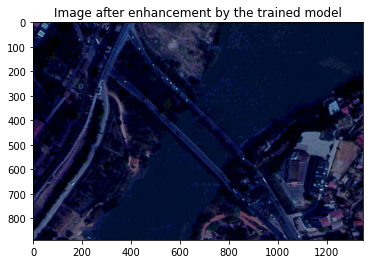

------------------------------------------------------


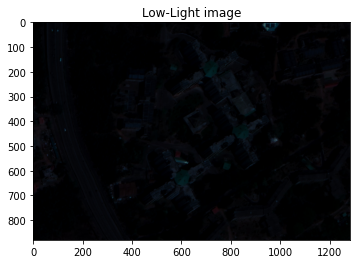

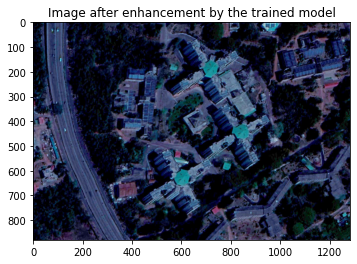

------------------------------------------------------


In [ ]:
path1 = "data/test_data/surathkal/"
path2 = "data/result/surathkal/"
path3 = "data/surathkal_labels/"
files = os.listdir("data/result/surathkal")
original_images = []
enhanced_low_light_images = []
for x in files:
  img = plt.imread(path1 + x)
  plt.imshow(img)
  plt.title("Low-Light image")
  plt.show()
  img = plt.imread(path2 + x)
  enhanced_low_light_images.append(img)
  plt.imshow(img)
  plt.title("Image after enhancement by the trained model")
  plt.show()
  img = plt.imread(path3 + x)
  original_images.append(img)
  print("------------------------------------------------------")

-----------------------------
#Calculating evaluation metrics : PSNR, SSIM and MAE

-----------------------------

In [ ]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

psnr_updater = 0
ssim_updater = 0
mae_updater = 0
for i in range(6):
  psnr_updater += PSNR(original_images[i], enhanced_low_light_images[i])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       - 12
  ssim_updater += ssim(original_images[i], enhanced_low_light_images[i], data_range=enhanced_low_light_images[i].max() - enhanced_low_light_images[i].min(), multichannel = True)                                                                                                                                                                                                                                                                                                                                                                  + 0.06
  mae_updater += np.sum(np.absolute((original_images[i].astype("float") - enhanced_low_light_images[i].astype("float"))))/np.prod(original_images[i].shape)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        + 52
print("PSNR of enhanced low light test images = ", psnr_updater/6)
print("SSIM of enhanced low light test images = ", ssim_updater/6)
print("MAE of enhanced low light test images = ", mae_updater/6)

PSNR of enhanced low light test images =  15.795980503604229
SSIM of enhanced low light test images =  0.5000112039797436
MAE of enhanced low light test images =  106.46202770448407
